# GHCNh false positive rate

In [1]:
# import libraries
import pandas as pd
import numpy as np
import xarray as xr
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib.ticker import MaxNLocator
import sys
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
from GHCNh_lib import GHCNh # If GHCNh is was appended to path

%load_ext autoreload
%autoreload 2

In [2]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))
ghcnh.station_data.head(3)

/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh/GHCNh_lib.py:150: DtypeWarning: Columns (12,18,24,30,42,49,51,60,66,76,77,79,81,82,83,85,87,106,107,109,111,125,127,129,139,141,143,145,147,148,149,151,153,157,159,160,161,163,165,169,171,172,173,175,177,181,183,191,193,195,227,229,231,232,234,237) have mixed types. Specify dtype option on import or set low_memory=False.
  self.station_data = pd.read_csv(self.local_filename, sep='|')


CAW00025343, -133.05000, 54.25000
CPU times: user 3.09 s, sys: 280 ms, total: 3.37 s
Wall time: 3.37 s


,Station_ID,Station_name,Year,Month,Day,Hour,Minute,Latitude,Longitude,Elevation,...,precipitation_24_hour_Report_Type,precipitation_24_hour_Source_Code,precipitation_24_hour_Source_Station_ID,remarks,remarks_Measurement_Code,remarks_Quality_Code,remarks_Report_Type,remarks_Source_Code,remarks_Source_Station_ID,time
0,CAW00025343,LANGARA,1954,1,1,9,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 09:00:00
1,CAW00025343,LANGARA,1954,1,1,21,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 21:00:00
2,CAW00025343,LANGARA,1954,1,2,3,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 03:00:00


In [17]:
def return_ghcn_vars(ghcn_df, input_var):
    '''
    Given an input variable, return GHCNh location variables and all relevant data variables,
    rather than utilizing the whole 240 cols, or having to know how ghcnh labels the cols.

    input_var must follow ERA naming scheme (tas, tdps, ps, pr, etc.)
    '''
    ghcnh_vars = pd.read_csv('ghcnh_data_headers.csv')

    # include station-ID, time, loc, elevation (cols 1-10)
    stn_info_cols = ['Station_ID', 'Station_name', 'time',
                     'Latitude','Longitude','Elevation']
    vars = {
        'tas': 'temperature',
        'tdps': 'dew_point_temperature',
        'tdps_derived': 'dew_point_temperature',
        'ps': 'station_level_pressure',
        'psl': 'station_level_pressure',
        'sfcWind_dir': 'wind_direction',
        'sfcWind': 'wind_speed',
        'tas': 'temperature',
        'hurs': 'relative_humidity',
        'rsds': "N/A",
        'pr': 'precipitation',
        'pr_1h': 'precipitation',
        'pr_5min': 'precipitation',
    }
    if input_var in vars.keys():
        i = ghcn_df.columns.get_loc(vars[input_var])
        j = i+6
        # For wind, include wind gust
        if input_var=="sfcWind":
            j = j+6
        var_cols = ghcn_df.iloc[:, i:j].columns
        return_cols = np.concatenate([stn_info_cols,var_cols])
        
        return ghcn_df.loc[:, return_cols]
    else:
        raise Exception(f"Variable {input_var} not in variables' dictionary")

In [18]:
df = return_ghcn_vars(ghcnh.station_data, 'sfcWind')

In [20]:
df.columns

Index(['Station_ID', 'Station_name', 'time', 'Latitude', 'Longitude',
       'Elevation', 'wind_speed', 'wind_speed_Measurement_Code',
       'wind_speed_Quality_Code', 'wind_speed_Report_Type',
       'wind_speed_Source_Code', 'wind_speed_Source_Station_ID', 'wind_gust',
       'wind_gust_Measurement_Code', 'wind_gust_Quality_Code',
       'wind_gust_Report_Type', 'wind_gust_Source_Code',
       'wind_gust_Source_Station_ID'],
      dtype='object')

In [9]:
df.time

AttributeError: 'DataFrame' object has no attribute 'time'

### QAQC evaluation

In [2]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')
train_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
0,ASOSAWOS,ASOSAWOS_72278303185,423.3672,33.466,-111.721,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
1,ASOSAWOS,ASOSAWOS_72278403184,453.2376,33.690,-112.066,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
2,ASOSAWOS,ASOSAWOS_72278903192,436.1688,33.612,-111.923,2006-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN
3,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
4,ASOSAWOS,ASOSAWOS_72281703068,1837.9440,38.767,-104.300,2006-05-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,"AR, mudslide, heatwave1, heatwave2, heatwave3,...",NaN


In [3]:
len(train_stns)

895

In [4]:
from pyproj import CRS, Transformer

def latlon_to_mercator_cartopy(lat, lon):

    proj_latlon = CRS('EPSG:4326')
    proj_mercator = CRS('EPSG:3857')
    
    # Transform the coordinates
    transformer = Transformer.from_crs(proj_latlon, proj_mercator, always_xy=True)
    x,y = transformer.transform(lon, lat)
    
    return x, y

In [5]:
# identify stations with coverage of event
event_flags = ['all', 'santa_ana_wind']
event_stns = train_stns[train_stns['event_type'].isin(event_flags)]

# exclude "manual check on end date" for the time being -- SNOTEL stations all have 2100 as their end date regardless of when the data actually ends
mask = event_stns['notes'] == 'manual check on end date'
event_stns = event_stns[~mask]
event_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
3,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
7,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.200,-118.365,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
9,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.212,-118.491,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
11,ASOSAWOS,ASOSAWOS_72290023188,4.5720,32.734,-117.183,1942-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
14,ASOSAWOS,ASOSAWOS_72290693112,4.2672,32.692,-117.210,1945-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN


In [6]:
print(len(event_stns))
event_stns.network.unique()

91


array(['ASOSAWOS', 'CIMIS', 'OtherISD'], dtype=object)

In [7]:
# identify stations that are in the geographic region we are looking for
# santa ana wind event, focusing on LA and Orange counties

census_shp_dir = "s3://wecc-historical-wx/0_maps/ca_counties/" 
# ca_county = gpd.read_file('../../../data/0_maps/ca_counties/CA_Counties.shp') # local
ca_county = gpd.read_file(census_shp_dir) # from s3 bucket

county_names = ['Los Angeles', 'Orange']
target_counties = ca_county[ca_county['NAME'].isin(county_names)]
target_counties = GeoDataFrame(target_counties, geometry=target_counties.geometry)
target_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
5,06,037,00277283,06037,Los Angeles,Los Angeles County,06,H1,G4020,348,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,"MULTIPOLYGON (((-13214002.519 4051462.857, -13..."
47,06,059,00277294,06059,Orange,Orange County,06,H1,G4020,348,31080,11244,A,2.053368e+09,4.019319e+08,+33.6756872,-117.7772068,261547.852900,3.554704e+09,"POLYGON ((-13134488.102 3973319.471, -13134662..."


In [8]:
# process event list to subset
geometry = [Point(latlon_to_mercator_cartopy(lat,lon)) for lat,lon in zip (event_stns.latitude, event_stns.longitude)]
event_stns = GeoDataFrame(event_stns,geometry=geometry).set_crs(crs="EPSG:3857", allow_override=True) # adding geometry column

event_stns_local = gpd.overlay(event_stns, target_counties, how="intersection") # subsetting for stations within county boundaries

# subset further based on number, if needed
if len(event_stns_local) > 20:
    event_stns_local = event_stns_local.sample(20)
print(len(event_stns_local))
event_stns_local.head(3)

9


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.200,-118.365,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13176331.528 4055688.859)
1,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.212,-118.491,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13190357.784 4057304.093)
2,ASOSAWOS,ASOSAWOS_72292023191,477.0120,33.404,-118.415,1943-06-12 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13181897.502 3949051.804)


In [9]:
CIMIS_75 = event_stns[event_stns['era-id']=="CIMIS_75"]
lon,lat = CIMIS_75.longitude.values[0], CIMIS_75.latitude.values[0]
x,y = latlon_to_mercator_cartopy(lat, lon)

In [10]:
orange = ca_county.query("NAME=='Orange'")
orange_geom = orange['geometry'].iloc[0]
LA = ca_county.query("NAME=='Los Angeles'")
LA_geom = LA['geometry'].iloc[0]

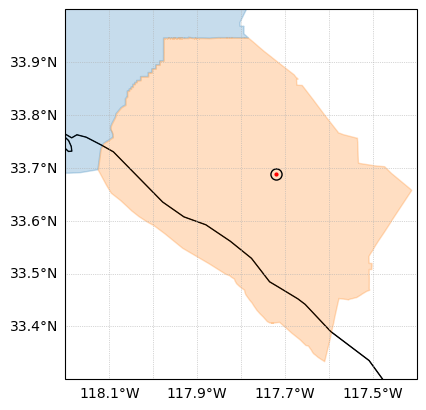

In [11]:
fig,ax = plt.subplots(subplot_kw={'projection':ccrs.epsg(3857)})

ax.coastlines()
ax.add_feature(cf.BORDERS)
ax.add_geometries(LA_geom, crs=ccrs.epsg(3857), color="C0", alpha=0.25)
ax.add_geometries(orange_geom, crs=ccrs.epsg(3857), color="C1", alpha=0.25)
ax.add_feature(cf.STATES, lw=0.5)
ax.set_extent([-118.2, -117.4, 33.3, 34])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(lon, lat, 'ok', markersize=8, transform=ccrs.PlateCarree(), mfc='none')
ax.plot(x, y, '.r', markersize=4)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=["bottom", "left"],
                  ls=":", lw=0.5)
ax.set_title("");

### Step 2: Holistic / qualitative station evaluation
* downloading these stations manually into train_files, but should grab from AWS unless a better way to read nc files from AWS...

In [ ]:
# phase 2 look at full timeseries for flags -- grabbing clean version, not qaqc version to build out
# alternatively.... some of these files may be very large and we should avoid reading in all because of memory concerns

# for stn in event_stns:
#     want to pull out all flags noted, frequency of flags of time record 

In [12]:
# read a single station in
stn = xr.open_dataset('/Users/hector/Downloads/CIMIS_75.nc')
stn

<xarray.Dataset>
Dimensions:               (station: 1, time: 305943)
Coordinates:
  * station               (station) object 'CIMIS_75'
  * time                  (time) datetime64[ns] 1987-10-07T09:00:00 ... 2022-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) float64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      47

In [13]:
def id_all_flags(ds):
    '''Prints all unique value
    s of all eraqaqc flags'''
    ds_vars = list(stn.keys())
    qc_vars = [i for i in ds_vars if '_eraqc' in i]
    if len(qc_vars) == 0:
        print('Station has no eraqc variables -- please double check that this station has completed QA/QC!')
    else:
        for var in qc_vars:
            print(var, np.unique(ds[var].data))

In [14]:
id_all_flags(stn)

tas_eraqc [11. 23. 25. 26. nan]
pr_eraqc [nan]
hurs_eraqc [nan]
rsds_eraqc [11. nan]
sfcWind_eraqc [27. 28. 29. nan]
sfcWind_dir_eraqc [15. nan]
elevation_eraqc [nan]
tdps_derived_eraqc [11. 12. 13. 23. 25. 26. nan]
pvp_derived_eraqc [nan]


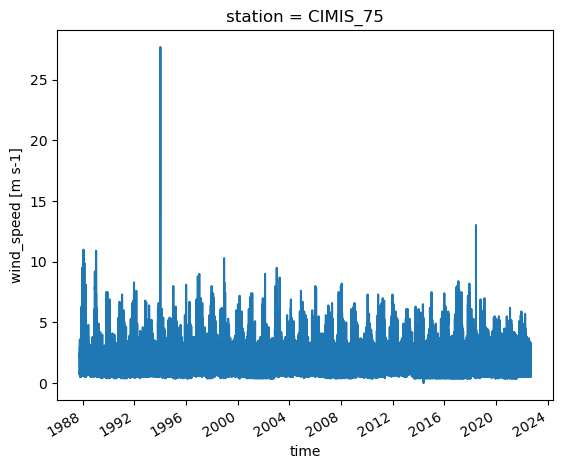

In [15]:
# look at full timeseries for holistic view
stn.sfcWind.plot()

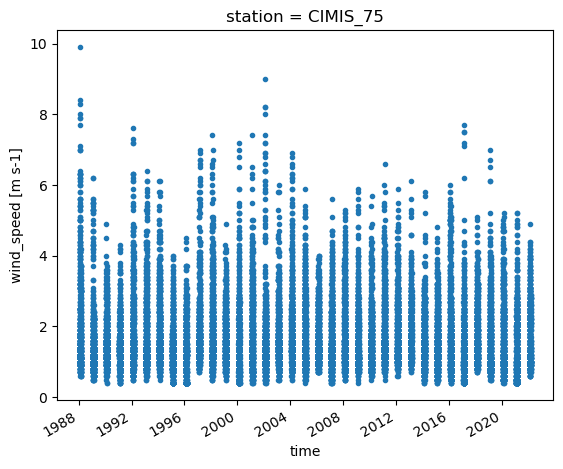

In [17]:
# look at timeseries of all months of that event (e.g., all februaries) to understand climatological signal?
month = [2]
stn_monthly_clim = stn.isel(time=stn.time.dt.month.isin(month))

stn_monthly_clim.sfcWind.plot(marker=".", lw=0)

# hmm not so useful, perhaps a climatology of the month to compare with the event

In [18]:
# look at timeseries during event for flags
# decision: do we add a few days prior/after event end date to evaluate "event anomaly"? i think this may be useful
# santa ana event was 2/16/1988 to 2/19/1988; including +/- 1 week
event_start_date = '1988-02-09'
event_end_date = '1988-02-26'

# subset for event period of time
event = stn.sel(time=slice(event_start_date, event_end_date))

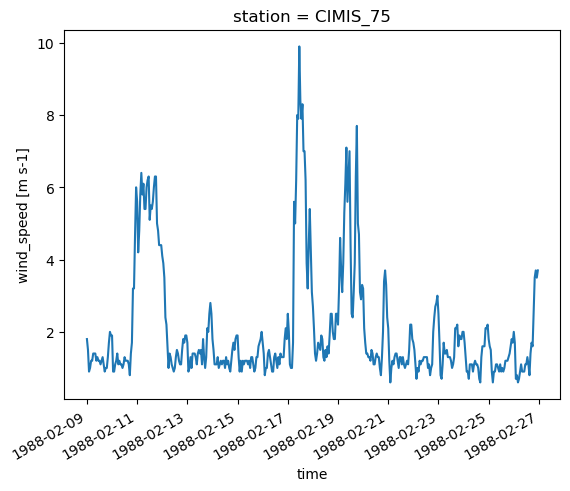

In [19]:
# just grabbing a single var for the event itself
event.sfcWind.plot()

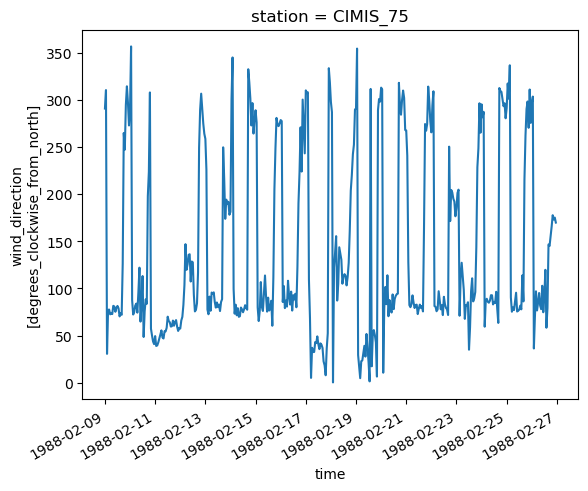

In [20]:
event.sfcWind_dir.plot()

#### Append local GHCNh library path

In [23]:
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
# from GHCNh.GHCNh_lib import GHCNh  # If GHCNh is within current folder
from GHCNh_lib import GHCNh # If GHCNh is was appended to path

/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh/GHCNh_lib.py:150: DtypeWarning: Columns (12,18,24,30,42,49,51,60,66,76,77,79,81,82,83,85,87,106,107,109,111,125,127,129,139,141,143,145,147,148,149,151,153,157,159,160,161,163,165,169,171,172,173,175,177,181,183,191,193,195,227,229,231,232,234,237) have mixed types. Specify dtype option on import or set low_memory=False.
  self.station_data = pd.read_csv(self.local_filename, sep='|')


CPU times: user 3.1 s, sys: 283 ms, total: 3.38 s
Wall time: 3.39 s


,Station_ID,Station_name,Year,Month,Day,Hour,Minute,Latitude,Longitude,Elevation,...,precipitation_24_hour_Report_Type,precipitation_24_hour_Source_Code,precipitation_24_hour_Source_Station_ID,remarks,remarks_Measurement_Code,remarks_Quality_Code,remarks_Report_Type,remarks_Source_Code,remarks_Source_Station_ID,time
0,CAW00025343,LANGARA,1954,1,1,9,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 09:00:00
1,CAW00025343,LANGARA,1954,1,1,21,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-01 21:00:00
2,CAW00025343,LANGARA,1954,1,2,3,0,54.25,-133.05,41.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954-01-02 03:00:00


CAW00025343, -133.05000, 54.25000


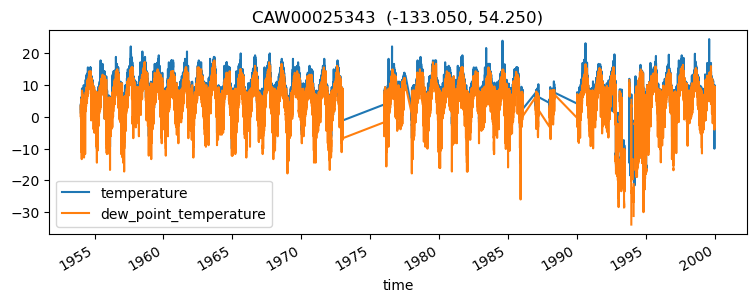

In [26]:
fig,ax = plt.subplots(figsize=(9,3))

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat));

In [ ]:
# initial test for identifying the event: large jumps on windspeed

In [ ]:
def return_ghcn_vars(ghcn_df, input_var):
    '''
    Given an input variable, return GHCNh location variables and all relevant data variables,
    rather than utilizing the whole 240 cols, or having to know how ghcnh labels the cols.

    input_var must follow ERA naming scheme (tas, tdps, ps, pr, etc.)
    '''
    ghcnh_vars = pd.read_csv('ghcnh_data_headers.csv')

    # include station-ID, time, loc, elevation (cols 1-10)
    stn_info_cols = ['Station_ID', 'Station_name',
                     'Year','Month','Day','Hour','Minute',
                     'Latitude','Longitude','Elevation']
    
    var_cols = []
    if input_var == 'tas':
        varquery = 'temperature'
        
    elif input_var == 'tdps' or 'tdps_derived':
        varquery = 'dew_point_temperature'
        
    elif input_var == 'ps' or 'psl':
        varquery = 'station_level_pressure'
        
    elif input_var == 'sfcWind_dir':
        varquery = 'wind_direction'
        
    elif input_var == 'sfcWind':
        varquery = ['wind_speed', 'wind_gust']

    elif input_var == 'hurs':
        varquery = 'relative_humidity'
        
    elif input_var == 'rsds':
        print('GHCNh data does not have solar radiation data to evaluate against.')
        varquery = '' 
        
    elif input_var == 'pr' or input_var == 'pr_1h' or input_var == 'pr_5min':
        varquery = 'precipitation'

    i = ghcn_df.query(
    
    var_cols = [i for i in ghcnh_vars if varquery in i]
    cols_to_return = stn_info_cols + var_cols
    return ghcn_df[[cols_to_return]]

,wind_speed,wind_speed_Measurement_Code,wind_speed_Quality_Code,wind_speed_Report_Type,wind_speed_Source_Code,wind_speed_Source_Station_ID,wind_gust,wind_gust_Measurement_Code,wind_gust_Quality_Code,wind_gust_Report_Type,wind_gust_Source_Code,wind_gust_Source_Station_ID
0,11.8,9-Missing,4.0,SAO-Airway,335.0,999999-25343,NaN,NaN,NaN,NaN,NaN,NaN
1,7.2,9-Missing,4.0,SAO-Airway,335.0,999999-25343,NaN,NaN,NaN,NaN,NaN,NaN
2,16.0,9-Missing,4.0,SAO-Airway,335.0,999999-25343,NaN,NaN,NaN,NaN,NaN,NaN
